# FasterR-CNN Training

## Table of contents
1. [Dataframes import](#df)<br>
2. [Dataset import](#dataset)<br>
3. [Albumentations](#alb)<br>
4. [Dataloaders](#datal)<br>
    4.1 [Colored images](#col_img)<br>
    4.2 [BW images](#bw_img)<br>
    4.3 [Undersampled images](#under_img)<br>
    4.4 [Oversampled images](#over_img)<br>
5. [Training](#tr)<br>
    5.1 [Augmented Model](#aug_m)<br>
    5.2 [BW Model](#bw_m)<br>
    5.3 [Undersampled Model](#under_m)<br>
    5.4 [Oversampled Model](#over_m)<br>

In [1]:
# importing libraries
import pandas as pd
import json
import os
import glob
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import seaborn as sn
import numpy as np
from PIL import Image
import torchvision
from typing_extensions import Concatenate
from torch.utils.data.sampler import Sampler
from torchvision import transforms, datasets, models
from torch.utils.data import Dataset
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import albumentations.pytorch
import albumentations
import cv2
import time
import torch
import pickle
from tqdm.notebook import tqdm

## FasterR-CNN Model and Device

In [2]:
import torch

if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")  
    
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


## 1. Importing Dataframes <a class="anchor" id="df"></a>

In [3]:
file = open("pickles_df/train.pickle", "rb")
train_df_final = pickle.load(file)
file.close()   

## 2. Dataset Class <a class="anchor" id="dataset"></a>

In [6]:
from SATM.dataset import AvesAugmentationDataset, SATMsampler, AvesStochAugDataset
from SATM.dataset import collate_fn, generate_box, generate_target, plot_image_from_output

## 3. Albumentations <a class="anchor" id="alb"></a>

In [7]:
# transformations we want to implement
transformations = [albumentations.MotionBlur(blur_limit=3, p=0.1),
                    albumentations.Blur(blur_limit=3, p=0.1),
                    albumentations.RandomBrightnessContrast(brightness_limit=0.2, p=0.1),
                    albumentations.ColorJitter(p=0.5),
                    albumentations.RandomGamma(p=0.2),
                    albumentations.RandomFog(p=0.5,fog_coef_upper= 0.5),
                    albumentations.MedianBlur(blur_limit=3, p=0.1),
                    albumentations.HorizontalFlip(p=0.5),
                    albumentations.Rotate(p=0.5)]

## 4. Dataloaders <a class="anchor" id="dl"></a>

### 4.1 Dataloader - Colored images <a class="anchor" id="col_img"></a>

In [8]:
path__= "data/images"

In [9]:
# defining the dataset class  and data loader for the train
train_augAves = AvesAugmentationDataset(path__ +'/Train', transform=transformations, df=train_df_final,num_aug=3)
train_data_loader = torch.utils.data.DataLoader(train_augAves, batch_size=16, collate_fn=collate_fn)

id: 25230
torch.Size([450, 800, 3])


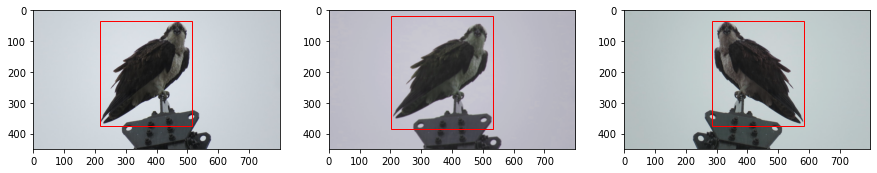

In [10]:
# visualizing a random image with its augementations
num = np.random.randint(1,len(train_augAves)//train_augAves.num_aug)
num *= 3

print("id:",num)

fig,ax = plt.subplots(1,train_augAves.num_aug,figsize=(15,10))

for i in range(train_augAves.num_aug):
    
    img, annot, _ = train_augAves[num+i]
    img = img.cpu().permute(1,2,0)

    ax[i].imshow(img)
    
    for idx in range(len(annot["boxes"])):
        
        xmin, ymin, xmax, ymax = annot["boxes"][idx]

        rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='red',facecolor='none')

        ax[i].add_patch(rect)

print(img.size())

### 4.2 Dataloader - BW images <a class="anchor" id="bw_img"></a>

In [11]:
path_bw = "data_bw/images"

In [12]:
# defining the dataset class  and data loader for the train
train_augAves_bw = AvesAugmentationDataset(path_bw +'/Train', transform=transformations, df=train_df_final,num_aug=3)
train_data_loader_bw = torch.utils.data.DataLoader(train_augAves_bw, batch_size=16, collate_fn=collate_fn)

id: 9234
torch.Size([533, 800, 3])


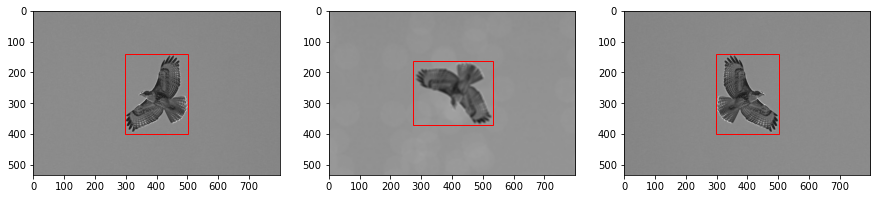

In [13]:
# visualizing a random image with its augementations
num = np.random.randint(1,len(train_augAves_bw)//train_augAves_bw.num_aug)
num *= 3

print("id:",num)

fig,ax = plt.subplots(1,train_augAves_bw.num_aug,figsize=(15,10))

for i in range(train_augAves_bw.num_aug):
    
    img, annot, _ = train_augAves_bw[num+i]
    img = img.cpu().permute(1,2,0)

    ax[i].imshow(img)
    
    for idx in range(len(annot["boxes"])):
        
        xmin, ymin, xmax, ymax = annot["boxes"][idx]

        rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='red',facecolor='none')

        ax[i].add_patch(rect)

print(img.size())

### 4.3 Dataloader - Under <a class="anchor" id="under_img"></a>

In [14]:
path__= "data/images"

In [15]:
labels = []
for i in tqdm(os.listdir("data/images/Train")):
    annot = i[:-3] + "txt" 
    with open(f"data/labels/Train/{annot}", "r") as txt:
        for l in txt:
            labels.append(int(l[:2]))
            break
labels = pd.Series(labels)

  0%|          | 0/17805 [00:00<?, ?it/s]

In [16]:
# defining the dataset class  and data loader for the train
train_augAves = AvesStochAugDataset(path__ +'/Train', transformations,
                                          train_df_final, labels, prop_aug=1)

under = 10000

sampler_under = SATMsampler(train_augAves, under, labels)
train_data_loader_under = torch.utils.data.DataLoader(train_augAves, batch_size=16, 
                                                      collate_fn=collate_fn, sampler = sampler_under)

### 4.4 Dataloader - Over <a class="anchor" id="over_img"></a>

In [17]:
path__= "data/images"

In [18]:
# defining the dataset class  and data loader for the train
train_augAves = AvesStochAugDataset(path__ +'/Train', transformations,
                                          train_df_final, labels, prop_aug=1)

over = 30000
sampler_over = SATMsampler(train_augAves, over, labels)
train_data_loader_over = torch.utils.data.DataLoader(train_augAves, batch_size=16, 
                                                      collate_fn=collate_fn, sampler = sampler_over)

## 5. FasterRCNN training <a class="anchor" id="tr"></a>

In [19]:
def get_model_instance_segmentation(num_classes):
  
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True,min_size=150,max_size=242)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [20]:
model = get_model_instance_segmentation(11)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(150,), max_size=242, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(i

In [21]:
# for all the model we will train 4 epochs and use the same parameters and optimizer
num_epochs = 4
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

### 5.1 Base Augmented Model <a class="anchor" id="aug_m"></a>

In [22]:
model_dir = "Model_Faster/Aug"

In [32]:
print('----------------------train start--------------------------')
for epoch in tqdm(range(num_epochs)):
    start = time.time()
    model.train()
    i = 0    
    epoch_loss = 0
    for imgs, annotations, _ in tqdm(train_data_loader):
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations) 
        losses = sum(loss for loss in loss_dict.values())        

        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 
        epoch_loss += losses
    
    file = open(f"{model_dir}/model_epoch{epoch+1}.pkl", "wb")
    pickle.dump(model,file)
    file.close()
    print(f'epoch : {epoch+1}, Loss : {epoch_loss}, time : {time.time() - start}')

----------------------train start--------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3339 [00:00<?, ?it/s]

/anaconda/envs/py38_default/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch : 1, Loss : 825.92822265625, time : 5627.586881399155


  0%|          | 0/3339 [00:00<?, ?it/s]

epoch : 2, Loss : 669.2989501953125, time : 5047.773880243301


  0%|          | 0/3339 [00:00<?, ?it/s]

epoch : 3, Loss : 625.8775634765625, time : 5054.940503120422


  0%|          | 0/3339 [00:00<?, ?it/s]

epoch : 4, Loss : 605.4271850585938, time : 5046.055244445801


### 5.2 BW Model <a class="anchor" id="bw_m"></a>

In [23]:
model_dir = "Model_Faster/BW"

In [32]:
print('----------------------train start--------------------------')
for epoch in tqdm(range(num_epochs)):
    start = time.time()
    model.train()
    i = 0    
    epoch_loss = 0
    for imgs, annotations, _ in tqdm(train_data_loader_bw):
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations) 
        losses = sum(loss for loss in loss_dict.values())        

        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 
        epoch_loss += losses
    
    file = open(f"{model_dir}/model_epoch{epoch+1}.pkl", "wb")
    pickle.dump(model,file)
    file.close()
    print(f'epoch : {epoch+1}, Loss : {epoch_loss}, time : {time.time() - start}')

----------------------train start--------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3339 [00:00<?, ?it/s]

/anaconda/envs/py38_default/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch : 1, Loss : 825.92822265625, time : 5627.586881399155


  0%|          | 0/3339 [00:00<?, ?it/s]

epoch : 2, Loss : 669.2989501953125, time : 5047.773880243301


  0%|          | 0/3339 [00:00<?, ?it/s]

epoch : 3, Loss : 625.8775634765625, time : 5054.940503120422


  0%|          | 0/3339 [00:00<?, ?it/s]

epoch : 4, Loss : 605.4271850585938, time : 5046.055244445801


### 5.3 Undersampled Model <a class="anchor" id="under_m"></a>

In [24]:
model_dir = "Model_Faster/Under"

In [32]:
print('----------------------train start--------------------------')
for epoch in tqdm(range(num_epochs)):
    start = time.time()
    model.train()
    i = 0    
    epoch_loss = 0
    for imgs, annotations in tqdm(train_data_loader_under):
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations) 
        losses = sum(loss for loss in loss_dict.values())        

        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 
        epoch_loss += losses
    
    file = open(f"{model_dir}/model_epoch{epoch+1}.pkl", "wb")
    pickle.dump(model,file)
    file.close()
    print(f'epoch : {epoch+1}, Loss : {epoch_loss}, time : {time.time() - start}')

----------------------train start--------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3339 [00:00<?, ?it/s]

/anaconda/envs/py38_default/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch : 1, Loss : 825.92822265625, time : 5627.586881399155


  0%|          | 0/3339 [00:00<?, ?it/s]

epoch : 2, Loss : 669.2989501953125, time : 5047.773880243301


  0%|          | 0/3339 [00:00<?, ?it/s]

epoch : 3, Loss : 625.8775634765625, time : 5054.940503120422


  0%|          | 0/3339 [00:00<?, ?it/s]

epoch : 4, Loss : 605.4271850585938, time : 5046.055244445801


### 5.4 Oversampled Model <a class="anchor" id="over_m"></a>

In [25]:
model_dir = "Model_Faster/Over"

In [32]:
print('----------------------train start--------------------------')
for epoch in tqdm(range(num_epochs)):
    start = time.time()
    model.train()
    i = 0    
    epoch_loss = 0
    for imgs, annotations in tqdm(train_data_loader_over):
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations) 
        losses = sum(loss for loss in loss_dict.values())        

        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 
        epoch_loss += losses
    
    file = open(f"{model_dir}/model_epoch{epoch+1}.pkl", "wb")
    pickle.dump(model,file)
    file.close()
    print(f'epoch : {epoch+1}, Loss : {epoch_loss}, time : {time.time() - start}')

----------------------train start--------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3339 [00:00<?, ?it/s]

/anaconda/envs/py38_default/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch : 1, Loss : 825.92822265625, time : 5627.586881399155


  0%|          | 0/3339 [00:00<?, ?it/s]

epoch : 2, Loss : 669.2989501953125, time : 5047.773880243301


  0%|          | 0/3339 [00:00<?, ?it/s]

epoch : 3, Loss : 625.8775634765625, time : 5054.940503120422


  0%|          | 0/3339 [00:00<?, ?it/s]

epoch : 4, Loss : 605.4271850585938, time : 5046.055244445801
